### Model Info: loss: loss: 0.1195 - accuracy: 0.9512 - val_loss: 0.1865 - val_accuracy: 0.9396
Data: Grid

ImageDataGenerator( \
    rescale=1. / 255, \
    shear_range=0.2, \
    zoom_range=0.2, \
    horizontal_flip=True)
   
batch_size = 64 \
image_width = 224 \
image_height = 224 
    
optimizer='rmsprop
epochs=20

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime, os
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPooling2D

import itertools    

from sklearn.metrics import confusion_matrix

In [2]:
# from keras.applications import VGG16

# # include top should be False to remove the softmax layer
# pretrained_model = VGG16(include_top=False, weights='imagenet')
# pretrained_model.summary()

### Extracting data from the following source

In [3]:
!wget "https://www.dropbox.com/s/rl0qbub4clah2w9/grid_version.tar"

--2022-04-11 21:17:24--  https://www.dropbox.com/s/rl0qbub4clah2w9/grid_version.tar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/rl0qbub4clah2w9/grid_version.tar [following]
--2022-04-11 21:17:24--  https://www.dropbox.com/s/raw/rl0qbub4clah2w9/grid_version.tar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca464efc19bb5d00e926f22d0a2.dl.dropboxusercontent.com/cd/0/inline/BjNpaB2tOg6kuQhp2nB3Mm1f_egidrbmN9Kb6XYL3pkLBQMLrhBUbGTXQO-ke14OPqDMdA6J7EDqISAISCOSlE-2K3cxEJZzQxksOtq9fxadv4MPfWcKmukbTjyEpX0Cy0hm4yly6YmW6vzba4rsH8bOZmGHSvPZkPUTYuirhyJdJQ/file# [following]
--2022-04-11 21:17:24--  https://uca464efc19bb5d00e926f22d0a2.dl.dropboxusercontent.com/cd/0/inline/BjNpaB2tOg6kuQhp2nB3Mm1f_egidrbmN9Kb6XYL3pkLBQMLrhBUbGTX

#### Unzip data to directory

In [4]:
!tar -xvf 'grid_version.tar'

grid_version/
grid_version/validate/
grid_version/.DS_Store
grid_version/train/
grid_version/train/grid_no_smoke/
grid_version/train/.DS_Store
grid_version/train/grid_smoke/
grid_version/train/grid_smoke/1529002100_+01140_05_03.png
grid_version/train/grid_smoke/1529003240_+02280_05_03.png
grid_version/train/grid_smoke/1499547403_+01140_03_06.png
grid_version/train/grid_smoke/1499547763_+01500_05_07.png
grid_version/train/grid_smoke/1529002880_+01920_05_03.png
grid_version/train/grid_smoke/1528759446_+02040_06_08.png
grid_version/train/grid_smoke/1528759506_+02100_06_04.png
grid_version/train/grid_smoke/1498418253_+01860_05_08.png
grid_version/train/grid_smoke/1498418493_+02100_04_09.png
grid_version/train/grid_smoke/1529001560_+00600_06_04.png
grid_version/train/grid_smoke/1499547283_+01020_04_06.png
grid_version/train/grid_smoke/1528759686_+02280_05_06.png
grid_version/train/grid_smoke/1529022805_+02100_05_05.png
grid_version/train/grid_smoke/1530740065_+01020_04_07.png
grid_version/t

In [5]:
# Save file paths as variables
# train_input_folder ='grid_version/train'
# validate_input_folder = 'grid_version/validate'

In [6]:
# Install for following function
!pip install imutils

#### This function ensures that data is randomly selected, then saved into new directories for use in the modeling stage
The function splits the data into three directies:
- sampled_train (default 0.85)
- sampled_validate (default 0.10)
- testing (default 0.5)

In [7]:
from imutils import paths
import os
import shutil
import random

def split_data(directory, validate_directory='validation', split_train=0.85, split_validate=0.1): 
    directories = [os.path.join(directory, o) for o in os.listdir(directory) 
                    if os.path.isdir(os.path.join(directory,o))]
    print(directories)
    
    # create file path variables
    new_train_dir = './sampled_train'
    new_val_dir = './sampled_validate'
    testing_dir = './testing'
    
    # remove existing directories and create empty directories
    if os.path.isdir(new_train_dir) is True:
        shutil.rmtree(new_train_dir)
        shutil.rmtree(new_val_dir)
        shutil.rmtree(testing_dir)
                
    os.makedirs(new_train_dir)
    os.makedirs(new_val_dir)
    os.makedirs(testing_dir)
    
    for directory in directories:
        image_paths = list(paths.list_images(directory))
    
        random.seed(32)
        random.shuffle(image_paths)
        image_paths

        # compute the training and testing split
        i = int(len(image_paths) * split_train)
        j = int(len(image_paths) * split_validate)
        
        train_paths = image_paths[:i]
        selected_for_validation_paths = image_paths[i:i+j]
        test_paths = image_paths[i+j:]

        for path in selected_for_validation_paths:
            category = os.path.basename(os.path.normpath(directory))
            dest_path = os.path.join(new_val_dir, category)
            if not os.path.exists(dest_path):
                os.makedirs(dest_path)
                print(f'validation path ==> {dest_path}')
            shutil.copy(path, dest_path)

        for path in train_paths:
            category = os.path.basename(os.path.normpath(directory))
            dest_path = os.path.join(new_train_dir, category)
            if not os.path.exists(dest_path):
                os.makedirs(dest_path)
                print(f'train path ==> {dest_path}')
            shutil.copy(path, dest_path)  
            
        for path in test_paths:
            category = os.path.basename(os.path.normpath(directory))
            dest_path = os.path.join(testing_dir, category)
            if not os.path.exists(dest_path):
                os.makedirs(dest_path)
                print(f'testing path ==> {dest_path}')
            shutil.copy(path, dest_path)  

In [8]:
# Remove print statements once all is swell in the world
split_data(directory='grid_version/train/', validate_directory='grid_version/validation')  

['grid_version/train/grid_no_smoke', 'grid_version/train/grid_smoke']
validation path ==> ./sampled_validate/grid_no_smoke
train path ==> ./sampled_train/grid_no_smoke
testing path ==> ./testing/grid_no_smoke
validation path ==> ./sampled_validate/grid_smoke
train path ==> ./sampled_train/grid_smoke
testing path ==> ./testing/grid_smoke


In [9]:
# Save newly generate file paths as variables
train_path = 'sampled_train'
validate_path = 'sampled_validate'
testing_path = 'testing'

### Image Augmentation

##### Image augmentation is used to enhance the size and quality of training datasets for the purpose of creating more accurate Deep Learning models. Image augmentation algorithms vary in how the types of augmentation or transformations take place. Some of the methods include geometric transformations, color space augmentations, kernel filters, feature space augmentation, to name a few. 

##### Many of the approaches used in this model were derived from the following source: (https://towardsdatascience.com/exploring-image-data-augmentation-with-keras-and-tensorflow-a8162d89b844) 

---

**Definitions of Methods Applied**

**preprocessing_function** = preprocess_input will convert the input images from RGB to BGR, \
then will zero-center each color channel with respect to the ImageNet dataset, without scaling.

**rescale** = re-scales image

**shear_range** = Shear transformation slants the shape of the image. This is different from rotation \
in the sense that in shear transformation, we fix one axis and stretch the image at a certain angle \
known as the shear angle. This creates a sort of ‘stretch’ in the image, which is not seen in rotation. \
shear_range specifies the angle of the slant in degrees.

**zoom_range** = A random zoom is obtained by the zoom_range argument. \
A zoom less than 1.0 magnifies the image, while a zoom greater than 1.0 zooms out of the image.

**horizonatal_flip** = The generator will generate images, which on a random basis, will be horizontally flipped.


In [10]:
#apply image augmentation
train_image_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
    
validate_image_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rescale=1. /255
)

testing_image_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rescale=1. /255
)

In [11]:
# Variables for model
batch_size = 64
image_width = 150 
image_height = 150 
classes = ['grid_no_smoke','grid_smoke']
color_mode="rgb"
IMAGE_WIDTH_HEIGHT = (image_width, image_height)

class_mode = 'binary'

#create train data generator flowing from `grid_version/train` folder
train_generator = train_image_generator.flow_from_directory(
            train_path,
            target_size=IMAGE_WIDTH_HEIGHT,
            batch_size=batch_size,
            classes=classes,
            color_mode=color_mode,
            class_mode=class_mode)
            
#create validation data generator flowing from `grid_version/validate` folder
validate_generator = validate_image_generator.flow_from_directory(
        validate_path,
        target_size=IMAGE_WIDTH_HEIGHT,
        batch_size=batch_size,
        classes=classes,
        color_mode=color_mode,
        class_mode=class_mode)

#create testing data generator flowing from `grid_version/validate` folder
testing_generator = testing_image_generator.flow_from_directory(
        testing_path,
        target_size=IMAGE_WIDTH_HEIGHT,
        batch_size=batch_size,
        classes=classes,
        color_mode=color_mode,
        class_mode=class_mode,
        shuffle=False)

Found 3090 images belonging to 2 classes.
Found 362 images belonging to 2 classes.
Found 184 images belonging to 2 classes.


In [14]:
# Ensure that .ipynb_checkpoints are not within `testing` folder

!rm -r testing/grid_smoke/.ipynb_checkpoints/
!rm -r testing/grid_no_smoke/.ipynb_checkpoints/

rm: cannot remove 'testing/grid_smoke/.ipynb_checkpoints/': No such file or directory
rm: cannot remove 'testing/grid_no_smoke/.ipynb_checkpoints/': No such file or directory


### Confirm Data Leakage is not Present

#### Check if there are any identical images between the `sampled_train` and `sampled_validate` folders (`grid_smoke` vs `grid_smoke` | `grid_no_smoke` vs `grid_no_smoke`)
Any identical images will be be printed out; therefore, zero outputs are the intended behavior.

In [16]:
!diff -srq sampled_validate/grid_smoke/ sampled_train/grid_smoke/ | grep identical

In [17]:
!diff -srq sampled_validate/grid_no_smoke/ sampled_train/grid_no_smoke/ | grep identical

#### Plot out a sample of images

In [18]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.

import matplotlib.pyplot as plt
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow((img * 255).astype(np.uint8)) # updated imshow to address clipping issues
        ax.axis('off')
    plt.tight_layout()
    plt.show()

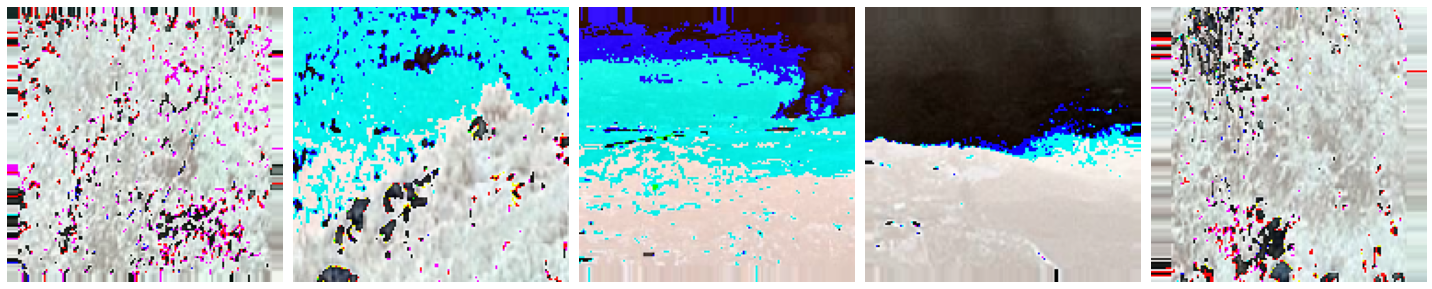

In [19]:
sample_training_images, _ = next(train_generator)
plotImages(sample_training_images[:100])

### Neural Network

In [20]:
input_shape = (image_width, image_height, 3)

In [21]:
model = Sequential()
model.add(Conv2D(32, 
                 kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
# output layer - binary // sigmoid
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


2022-04-11 21:17:46.657054: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [22]:
epochs = 10
steps_per_epoch = train_generator.n // train_generator.batch_size
test_steps = validate_generator.n // validate_generator.batch_size

logdir = os.path.join("tf_logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = model.fit(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      validation_data=validate_generator,
      validation_steps=test_steps,
      epochs=epochs,
      callbacks=[tensorboard_callback])

Epoch 1/10
48/48 [==============================] - 59s 1s/step - loss: 0.3882 - accuracy: 0.7971 - val_loss: 0.2471 - val_accuracy: 0.9062
Epoch 2/10
48/48 [==============================] - 57s 1s/step - loss: 0.2129 - accuracy: 0.9151 - val_loss: 0.1596 - val_accuracy: 0.9438
Epoch 3/10
48/48 [==============================] - 57s 1s/step - loss: 0.1691 - accuracy: 0.9445 - val_loss: 0.0856 - val_accuracy: 0.9719
Epoch 4/10
48/48 [==============================] - 58s 1s/step - loss: 0.1219 - accuracy: 0.9603 - val_loss: 0.0987 - val_accuracy: 0.9375
Epoch 5/10
48/48 [==============================] - 57s 1s/step - loss: 0.1217 - accuracy: 0.9627 - val_loss: 0.1143 - val_accuracy: 0.9500
Epoch 6/10
48/48 [==============================] - 58s 1s/step - loss: 0.1140 - accuracy: 0.9643 - val_loss: 0.0439 - val_accuracy: 0.9875
Epoch 7/10
48/48 [==============================] - 56s 1s/step - loss: 0.0798 - accuracy: 0.9746 - val_loss: 0.0272 - val_accuracy: 0.9906
Epoch 8/10
48/48 [==

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [24]:
history.history

{'loss': [0.38822394609451294,
  0.2128888964653015,
  0.16909612715244293,
  0.12187656760215759,
  0.12166423350572586,
  0.11401931941509247,
  0.07977858185768127,
  0.08233118802309036,
  0.10539427399635315,
  0.07049389183521271],
 'accuracy': [0.7970918416976929,
  0.9150694012641907,
  0.9444811344146729,
  0.9603436589241028,
  0.9626569747924805,
  0.9643093347549438,
  0.9745538830757141,
  0.970588207244873,
  0.970588207244873,
  0.9771976470947266],
 'val_loss': [0.24709665775299072,
  0.159572035074234,
  0.08561179786920547,
  0.09866557270288467,
  0.11427263915538788,
  0.043932169675827026,
  0.027208492159843445,
  0.02700207009911537,
  0.029777374118566513,
  0.0264426376670599],
 'val_accuracy': [0.90625,
  0.9437500238418579,
  0.971875011920929,
  0.9375,
  0.949999988079071,
  0.987500011920929,
  0.9906250238418579,
  0.984375,
  0.9906250238418579,
  0.981249988079071]}

Text(0.5, 0, 'epoch')

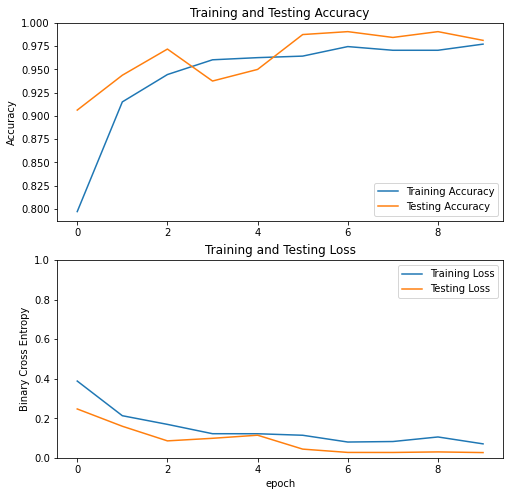

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Testing Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Testing Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Testing Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Testing Loss')
plt.xlabel('epoch')

### Predictions
Not sure what I need to do here... still trying to figure this out!

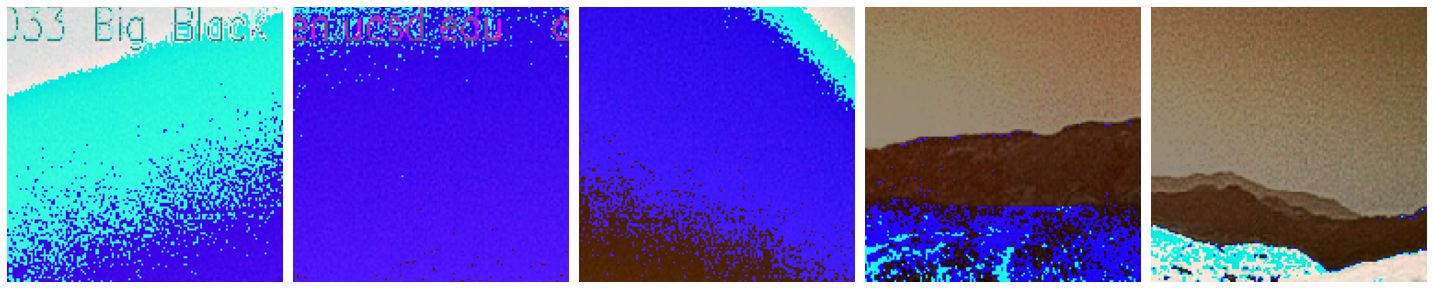

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [26]:
test_imags, test_labels = next(testing_generator)
plotImages(test_imags)
print(test_labels)

In [27]:
testing_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [28]:
predictions = model.predict(x=testing_generator, verbose=0)

In [29]:
np.round(predictions)[:10]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [30]:
cm = confusion_matrix(y_true=testing_generator.classes, y_pred=np.round(predictions))

In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [32]:
testing_generator.class_indices

{'grid_no_smoke': 0, 'grid_smoke': 1}

Confusion matrix, without normalization
[[133   0]
 [  1  50]]


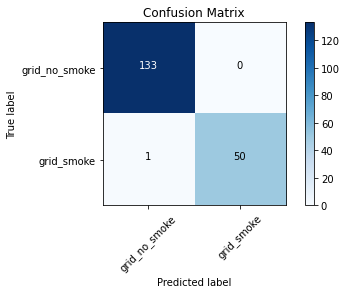

In [33]:
cm_plot_labels = ['grid_no_smoke','grid_smoke']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, normalize=False, title='Confusion Matrix')

#### Visualize Filters and Feature Maps in Convolutional Neural Networks

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [37]:
model.layers

In [55]:
# get filter weights
filters, biases = layer.get_weights()
print(layer.name, filters.shape)

ValueError: not enough values to unpack (expected 2, got 0)

In [69]:
for layer in model.layers:
    # check for convulation layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

conv2d (3, 3, 3, 32)
conv2d_1 (3, 3, 32, 32)
conv2d_2 (3, 3, 32, 64)


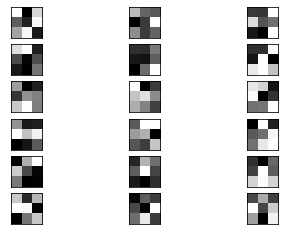

In [70]:
import matplotlib.pyplot as plt

# retrieve weights from the 1st hidden layer
model.layers[0].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1
# show the figure
plt.show()

In [71]:
# summarize feature map shapes
for i in range(len(model.layers)):
    layer = model.layers[i]
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # summarize output shape
    print(i, layer.name, layer.output.shape)

0 conv2d (None, 148, 148, 32)
2 conv2d_1 (None, 72, 72, 32)
4 conv2d_2 (None, 34, 34, 64)


In [74]:

# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(predictions[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
plt.show()

SyntaxError: invalid syntax (4127006648.py, line 11)

In [34]:
hand drawn picture of smoke

cauliflower on marble tap top / brocolli

tree picture

SyntaxError: invalid syntax (3375238134.py, line 1)